# Data Preprocessing

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms, datasets
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, sampler
# from skimage import io, transform 

USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [2]:
# Global constants
DATA_DIR = "VireoFood172"
LABELS_DIR = DATA_DIR + "/SplitAndIngreLabel" # VireoFood172/SplitAndIngreLabel
EXAMPLES_DIR = DATA_DIR + "/ready_chinese_food" # VireoFood172/ready_chinese_food

FOOD_LIST_PATH = LABELS_DIR + "/FoodList.txt" # VireoFood172/SplitAndIngreLabel/FoodList.txt
INGREDIENT_LIST_PATH = LABELS_DIR + "/IngredientList.txt" # VireoFood172/SplitAndIngreLabel/IngredientList.txt
INGRE_LABEL_PATH = LABELS_DIR + "/IngreLabel.txt"

NORMALIZE_ON = True # Enable data normalization
TRANSFORM_ON = True # Enable data transformations.

In [3]:
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()

ingredient_names = [] # List of length 353 where index is the ingredient label, and value is the ingredient name.
with open(INGREDIENT_LIST_PATH) as fp:
    ingredient_names = fp.read().splitlines()

print("Number of food labels {}".format(len(food_names)))
print("Number of ingredient labels {}".format(len(ingredient_names)))

Number of food labels 172
Number of ingredient labels 353


In [4]:
# General Data Utils

def get_food_label(image_path):
    ''' Takes in a path of the form: "VireoFood172/ready_chinese_food/100/xiachufang_1.jpg"
        and returns the label 99 (since we'll use 0-indexed labels). '''
    split_path = image_path.split("/")
    assert(len(split_path) == 4)
    return int(split_path[2]) - 1

def get_relative_image_path(path):
    ''' Takes in a path of the form: /100/xiachufang_1.jpg
        and returns the relative path to the image: 
        "VireoFood172/ready_chinese_food/100/xiachufang_1.jpg" '''
    return EXAMPLES_DIR + path

In [5]:
# Data Utils to extract data from the files in SplitAndIngreLabel/ directory.

def get_ingre_label_annotations(ingre_label_file):
    ''' Input: ingre_label_file: "VireoFood172/SplitAndIngreLabel/IngreLabel.txt"
        Returns image_paths: a list of all the 110241 image paths.
        Returns image_data_map: a dictionary of the form: {image_path : image_data}.
        image_data is another map containing data about the image (such as the food label and ingredient label)'''
    image_paths = []
    image_data_map = dict()
    with open(ingre_label_file) as fp:
        for line in fp.readlines():
            line = line.split()
            path, ingredient_label = line[0], list(map(int, line[1:]))
            image_path = get_relative_image_path(path)
            food_label = get_food_label(image_path)
            
            image_data = dict()
            image_data["food_label"] = food_label
            image_data["image_path"] = image_path
            image_data["ingredient_label"] = ingredient_label
            image_data_map[image_path] = image_data
            
            image_paths.append(image_path)
            
    return image_paths, image_data_map

def get_file_annotations(mode):
    ''' Input: mode (one of "TR", "VAL", or "TE")
        Returns image_paths: a list of all the training, validation, or testing image paths (depending
        on the specified "mode").
    '''
    assert(mode == "TR" or mode == "VAL" or mode == "TE")
    file = LABELS_DIR + "/{}.txt".format(mode)
    image_paths = []
    with open(file) as fp:
        for line in fp.readlines():
            image_path = get_relative_image_path(line.strip())
            image_paths.append(image_path)
    return image_paths

In [6]:
# Print out statistics about the extracted data.

train_image_paths = get_file_annotations("TR")    
val_image_paths = get_file_annotations("VAL")            
test_image_paths = get_file_annotations("TE")
(all_image_paths, image_data_map) = get_ingre_label_annotations(INGRE_LABEL_PATH)

print("Number of Training examples: {}".format(len(train_image_paths)))
print("Number of Validation examples: {}".format(len(val_image_paths)))
print("Number of Testing examples: {}".format(len(test_image_paths)))
print("Number of Total examples: {}".format(len(all_image_paths)))

assert(len(all_image_paths) == len(image_data_map))

Number of Training examples: 66071
Number of Validation examples: 11016
Number of Testing examples: 33154
Number of Total examples: 110241


In [7]:
# Examine the data stored in image_data_map.

for image_path in image_data_map:
    image_data = image_data_map[image_path]
    print("{} - food label: {}".format(image_path, image_data["food_label"]))
    print("{} - ingredient label: {}".format(image_path, image_data["ingredient_label"]))
    break

VireoFood172/ready_chinese_food/100/xiachufang_1.jpg - food label: 99
VireoFood172/ready_chinese_food/100/xiachufang_1.jpg - ingredient label: [1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

In [8]:
# Build a Custom Dataset

class FoodImagesDataset(Dataset):

    def __init__(self, ingre_label_file, mode=None, transform=None):
        self.ingre_label_file = ingre_label_file
        self.mode = mode
        (self.all_image_paths, self.image_data_map) = get_ingre_label_annotations(ingre_label_file)
        if mode is not None:
            self.image_paths = get_file_annotations(mode)
        self.mode = mode
        self.transform = transform
  
    def __len__(self):
        if self.mode is not None:
            return len(self.image_paths)
        return len(self.all_image_paths)

    def __getitem__(self, idx):
        if self.mode is not None:
            image_path = self.image_paths[idx]
        else:
            image_path = self.all_image_paths[idx]
        
        image_data = self.image_data_map[image_path]
        label = image_data["food_label"]
        if TRANSFORM_ON:
            image = Image.open(image_path)
            image = image.convert("RGB") # Some images are (256, 256, 3), others are (256, 256)
            sample = {'image': image, 'label': label, 'path': image_path}
        else:
            sample = {'image': plt.imread(image_path).copy(), 'label': label, 'path': image_path}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [9]:
# Here we set up a transform to preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.

transform = None
if TRANSFORM_ON:
    transform = T.Compose([T.ToTensor()])
    
    if NORMALIZE_ON:
        transform = T.Compose([
                    T.ToTensor(),
                    # per-channel mean and standard deviation are computed below.
                    T.Normalize((0.6007, 0.5071, 0.3860), (0.2766, 0.2894, 0.3107))
                ])

# Build Custom Dataset objects for the full dataset, and training/validation/testing splits.
train_dataset = FoodImagesDataset(INGRE_LABEL_PATH, mode="TR", transform=transform)
val_dataset = FoodImagesDataset(INGRE_LABEL_PATH, mode="VAL", transform=transform)
test_dataset = FoodImagesDataset(INGRE_LABEL_PATH, mode="TE", transform=transform)
full_dataset = FoodImagesDataset(INGRE_LABEL_PATH, transform=transform)

In [10]:
# Print out basic statistics about the custom datasets.

print("Number of Training examples: {}".format(len(train_dataset)))
print("Number of Validation examples: {}".format(len(val_dataset)))
print("Number of Testing examples: {}".format(len(test_dataset)))
print("Number of Total examples: {}".format(len(full_dataset)))

Number of Training examples: 66071
Number of Validation examples: 11016
Number of Testing examples: 33154
Number of Total examples: 110241


Sample image path: VireoFood172/ready_chinese_food/1/21_20.jpg
Sample image shape: torch.Size([3, 256, 256])
Sample image food label: 0, Braised Pork


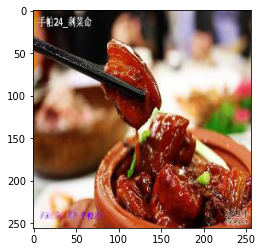

In [11]:
# Examine one of the examples in the training dataset.
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print("Sample image path: {}".format(sample["path"]))
    print("Sample image shape: {}".format(sample["image"].shape))
    print("Sample image food label: {}, {}".format(sample["label"], food_names[sample["label"]]))
    
    image = sample["image"]
    
    if NORMALIZE_ON:
        image = image.permute(1, 2, 0)
        mean = np.array([0.6007, 0.5071, 0.3860])
        std_dev = np.array([0.2766, 0.2894, 0.3107])
        image = np.clip(std_dev * image.numpy() + mean, 0, 1)
    plt.imshow(image)
    # plt.imshow(sample["image"].astype('uint8'))
    break

In [201]:
# Examine shapes in training/validation/testing datasets.

def examine_shapes(dataset):
    expected_shape = (3, 256, 256) if TRANSFORM_ON else (256, 256, 3)
    count = 0
    for i in range(len(dataset)):
        if count % 10000 == 0:
            print("Images seen so far: {}".format(count))
        sample = train_dataset[i]
        if sample["image"].shape != expected_shape:
            print("{} has shape{}".format(sample["path"], sample["image"].shape))
        count += 1

examine_shapes(train_dataset)
# examine_shapes(val_dataset)
# examine_shapes(test_dataset)

Images seen so far: 0
Images seen so far: 10000
Images seen so far: 20000
Images seen so far: 30000
Images seen so far: 40000
Images seen so far: 50000
Images seen so far: 60000


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [13]:
# Get a batch of data in the train_dataloader.
for i, example_dict in enumerate(train_dataloader):
    print(example_dict['image'].shape, example_dict['label'])
    break

torch.Size([64, 3, 256, 256]) tensor([ 25,  42,  65,  31,   2,  16, 163,  28, 100,   0,  27, 137,  59,  75,
         99,  42,  80, 168, 159, 156,  58, 135, 149,  71,  26,  83,  33,  12,
        149,  71, 148,  75, 160,   5,  96,  69,  73,  12, 163, 169,  54,  58,
         85,  27,  74, 140,  55, 122,  70, 112,   9, 134, 150, 116, 140, 127,
         52,  27,   9, 101,  68,  33, 167, 120])


In [14]:
full_dataloader = DataLoader(full_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Computing Per-Channel Mean

In [15]:
def compute_per_channel_stats(dataloader):
    N = 0 # number of examples
    means = torch.zeros(3) # [mu_R, mu_G, mu_B]
    means_sq = torch.zeros(3) # [sigma_R, sigma_G, sigma_B]
    for i, example_dict in enumerate(dataloader):
        image_batch = example_dict['image']
        batch_size = image_batch.shape[0]
        N += batch_size
        
        batch_mean = image_batch.mean(axis=(0,2,3))
        batch_mean_sq = (image_batch ** 2).mean(axis=(0,2,3))
        means += batch_size * batch_mean
        means_sq += batch_size * batch_mean_sq
        
    means = means / N
    means_sq = means_sq / N
    stds = torch.sqrt(means_sq - means**2)
    return (means, stds)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
means, stds = compute_per_channel_stats(train_dataloader)
print("Mean R/G/B: ", means)
print("Standard Deviation R/G/B: ", stds)

Mean R/G/B:  tensor([ 1.2937e-04, -2.2601e-05,  5.0625e-05])
Standard Deviation R/G/B:  tensor([1.0001, 1.0001, 1.0001])


In [16]:
# TESTING Mean/Standard Deviation calculation

# Compute mean and std dev across R/G/B channels for a SINGLE batch.
all_training_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
num_examples = 0
means = torch.zeros(3)
means_sq = torch.zeros(3)
for i, example_dict in enumerate(all_training_dataloader):
    image_batch = example_dict['image']
    batch_size = image_batch.shape[0]
    num_examples += batch_size
    mean_i = image_batch.mean(axis=(0,2,3))
    mean_sq_i = (image_batch ** 2).mean(axis=(0,2,3))
    means += batch_size * mean_i
    means_sq += batch_size * mean_sq_i
    break

means = means / num_examples
means_sq = means_sq / num_examples
stds = torch.sqrt(means_sq - means**2)

print("Image Batch Statistics... (BEFORE NORMALIZATION)")
print("Image Batch Shape: ", image_batch.shape)
print("Image Batch Mean: ", image_batch.mean(axis=(0,2,3)))
print("Image Batch Standard Deviation: ", image_batch.std(axis=(0,2,3)))
print("")

print("Computed Statistics...")
print("Computed Mean R/G/B: ", means)
print("Computed Standard Deviation R/G/B: ", stds)
print("")

# Normalize all the images using the computed mean/standard deviation.
norm_image_batch = (image_batch.permute(0, 2, 3, 1) - means) / stds

# Compute the mean and standard deviation across the normalized images.
# These should now be 0-mean, unit-variance.
print("Image Batch Statistics... (AFTER NORMALIZATION)")
print("Normalized Image Batch Mean", norm_image_batch.mean(axis=(0,1,2)))
print("Normalized Image Batch Standard Deviation", norm_image_batch.std(axis=(0,1,2)))

Image Batch Statistics... (BEFORE NORMALIZATION)
Image Batch Shape:  torch.Size([64, 3, 256, 256])
Image Batch Mean:  tensor([-0.0640, -0.2043, -0.0791])
Image Batch Standard Deviation:  tensor([1.0381, 1.1009, 1.0441])

Computed Statistics...
Computed Mean R/G/B:  tensor([-0.0640, -0.2043, -0.0791])
Computed Standard Deviation R/G/B:  tensor([1.0381, 1.1009, 1.0441])

Image Batch Statistics... (AFTER NORMALIZATION)
Normalized Image Batch Mean tensor([-2.1420e-08, -1.3039e-08, -2.7940e-09])
Normalized Image Batch Standard Deviation tensor([1.0000, 1.0000, 1.0000])


# Baseline Model

In [17]:
model_vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/vivekshankar/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [18]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [269]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, example_dict in enumerate(dl):
            print(t)
            x = example_dict["image"]
            # print(x.shape)
            y = example_dict["label"]
            # print(y.shape)
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            print(scores.shape)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                # check_accuracy_part34(dl, model)
                print()

In [270]:
def check_accuracy_part34(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [271]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
model = nn.Sequential(
    nn.Conv2d(3, channel_1, kernel_size=5, padding=2, bias=True),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1, bias=True),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 256 * 256, 172),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

In [272]:
print_every = 10
dl = DataLoader(train_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(640)))
train_part34(model, optimizer, epochs=10)

torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
Iteration 0, loss = 5.2081

torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
Iteration 0, loss = 5.2498

torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])
torch.Size([64, 172])
torch.Size([64, 3, 256, 256])
torch.Size([64])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/vivekshankar/opt/anaconda3/envs/cs231n/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-272-d58fc851f07b>", line 3, in <module>
    train_part34(model, optimizer, epochs=10)
  File "<ipython-input-269-e0c879a3eca7>", line 33, in train_part34
    loss.backward()
  File "/Users/vivekshankar/opt/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/tensor.py", line 245, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/Users/vivekshankar/opt/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/autograd/__init__.py", line 147, in backward
    allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/vivekshankar/opt/a

KeyboardInterrupt: 

# Miscellaneous / Testing

In [ ]:
# TODO:

# 1) Read through the custom datasets links.
# 2) Add a transform to convert the data to Pytorch tensors (DONE)
# 3) Fix the data: there are some (256, 256, 4) and (256, 256) numpy arrays (DONE)

In [205]:
# Processing an image that is (256, 256, 4) (includes a transparency channel)

image = Image.open("VireoFood172/ready_chinese_food/13/3_32.jpg")
print(array.shape)
print(type(array.copy()))
image = image.convert("RGB")
print(np.asarray(image).shape)
image_array = np.asarray(image)
print(image_array[0][0][1], image_array[0][0][0], image_array[0][0][2])

(256, 256, 4)
<class 'numpy.ndarray'>
(256, 256, 3)
57 57 57


In [254]:
for i, example_dict in enumerate(train_dataloader):
    print(example_dict['image'].shape, example_dict['label'])
    break

torch.Size([64, 3, 256, 256]) tensor([142,  72,  83, 111,  53,  34, 141,  84,  40, 148,  67, 132, 157, 145,
        155,  78,  84,  68, 135,  48, 116,  74,  43,  24,  42,  45, 120,  87,
         76,  68,   1,  53,  31, 132,  88, 164,  88, 106, 121,  63, 146, 138,
        109, 140, 112,  51, 139,  32, 147,  43,   4,  31,   2,  69,  14,  42,
         11,  66, 121, 149,  17, 126,  34,  43])
